# CBOW

In [1]:
import sys
sys.path.append('../..')
import numpy as np
from common.util import preprocess

In [2]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

## 맥락과 타깃 생성

In [3]:
def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return:
    '''
    target = corpus[window_size:-window_size] # 양 끝 제외
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [4]:
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


In [5]:
print(target)

[1 2 3 4 1 5]


## 원핫 표현으로 변환

In [6]:
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환

    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [7]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [8]:
print(target)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


In [9]:
print(contexts)

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


## CBOW 모델 구현

In [10]:
from common.layers import MatMul, SoftmaxWithLoss

In [11]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

In [12]:
from common.optimizer import Adam
from common.trainer import Trainer

In [13]:
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic') # 폰트 지정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format='retina' # 그래프 글씨 뚜렷

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 357 |  반복 1 / 2 | 시간 0[s] | 손실 0.83
| 에폭 358 |  반복 1 / 2 | 시간 0[s] | 손실 0.86
| 에폭 359 |  반복 1 / 2 | 시간 0[s] | 손실 0.87
| 에폭 360 |  반복 1 / 2 | 시간 0[s] | 손실 0.86
| 에폭 361 |  반복 1 / 2 | 시간 0[s] | 손실 0.83
| 에폭 362 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 363 |  반복 1 / 2 | 시간 0[s] | 손실 0.94
| 에폭 364 |  반복 1 / 2 | 시간 0[s] | 손실 0.86
| 에폭 365 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 366 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 367 |  반복 1 / 2 | 시간 0[s] | 손실 0.97
| 에폭 368 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 369 |  반복 1 / 2 | 시간 0[s] | 손실 0.77
| 에폭 370 |  반복 1 / 2 | 시간 0[s] | 손실 0.93
| 에폭 371 |  반복 1 / 2 | 시간 0[s] | 손실 0.84
| 에폭 372 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 373 |  반복 1 / 2 | 시간 0[s] | 손실 0.72
| 에폭 374 |  반복 1 / 2 | 시간 0[s] | 손실 0.93
| 에폭 375 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 376 |  반복 1 / 2 | 시간 0[s] | 손실 0.92
| 에폭 377 |  반복 1 / 2 | 시간 0[s] | 손실 0.80
| 에폭 378 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 379 |  반복 1 / 2 | 시간 0[s] | 손실 0.76
| 에폭 380 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 381 |  반복 1

| 에폭 742 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 743 |  반복 1 / 2 | 시간 0[s] | 손실 0.42
| 에폭 744 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 745 |  반복 1 / 2 | 시간 0[s] | 손실 0.74
| 에폭 746 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 747 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 748 |  반복 1 / 2 | 시간 0[s] | 손실 0.36
| 에폭 749 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 750 |  반복 1 / 2 | 시간 0[s] | 손실 0.42
| 에폭 751 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 752 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 753 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 754 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 755 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 756 |  반복 1 / 2 | 시간 0[s] | 손실 0.48
| 에폭 757 |  반복 1 / 2 | 시간 0[s] | 손실 0.72
| 에폭 758 |  반복 1 / 2 | 시간 0[s] | 손실 0.63
| 에폭 759 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 760 |  반복 1 / 2 | 시간 0[s] | 손실 0.49
| 에폭 761 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 762 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 763 |  반복 1 / 2 | 시간 0[s] | 손실 0.42
| 에폭 764 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 765 |  반복 1 / 2 | 시간 0[s] | 손실 0.74
| 에폭 766 |  반복 1

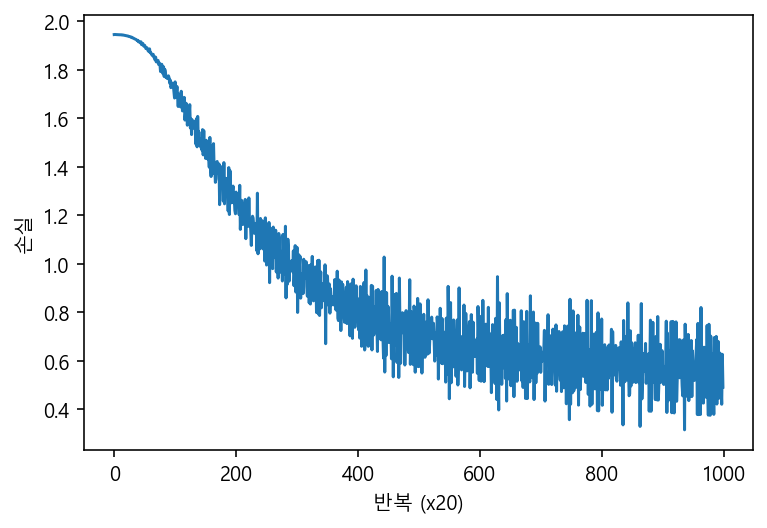

you [ 1.0109489  1.2768416 -1.1933718 -1.2364928  1.1650512]
say [-1.2508948  -0.14314194  0.28985268  1.2918601  -1.2271048 ]
goodbye [ 1.0062374   0.640342   -0.68843925 -0.6748381   0.86833614]
and [-1.0548326 -1.6074748  1.6057719  1.0920261 -1.0735213]
i [ 1.0465517   0.63019454 -0.6962789  -0.70833635  0.87963647]
hello [ 1.024346   1.2779654 -1.1788489 -1.2336466  1.1560476]
. [-1.0752239  1.4501889 -1.5051455  1.0715494 -0.9001689]


In [14]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id) # 7
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

# Skip-gram 모델

In [15]:
class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None